############# 1. Caracteristicas: 15 ###############
############# 2. Division de datos #############
TRAIN: [  7796 125997 128659 ...  86037 124109  49000] TEST: [ 55076   4502  32946 ... 100259  97820  76556] 

TRAIN: [113815  83804  50153 ...  41483  16120  43324] TEST: [  5501  81943 108306 ...  68954  53393 109653] 

TRAIN: [ 14448  86609 119950 ... 107651 133072   9240] TEST: [77429 65710 19312 ... 61056 64365 90679] 

TRAIN: [124218  76780  46969 ... 123532  67381  49343] TEST: [ 7411 56756 44347 ... 17245  3822   788] 

TRAIN: [130574  12785  24997 ...  29575  74460  72186] TEST: [110946  84715 127594 ...  72033  90596  51781] 

############ 3. Seleccionando modelo #############
Mejores hiperparametros:  {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 11, 'splitter': 'best'}
Mejor puntuacion:  0.9921692251461988
Modelo:  DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                       criterion='entropy', max_depth=11, random_state=1)
##########

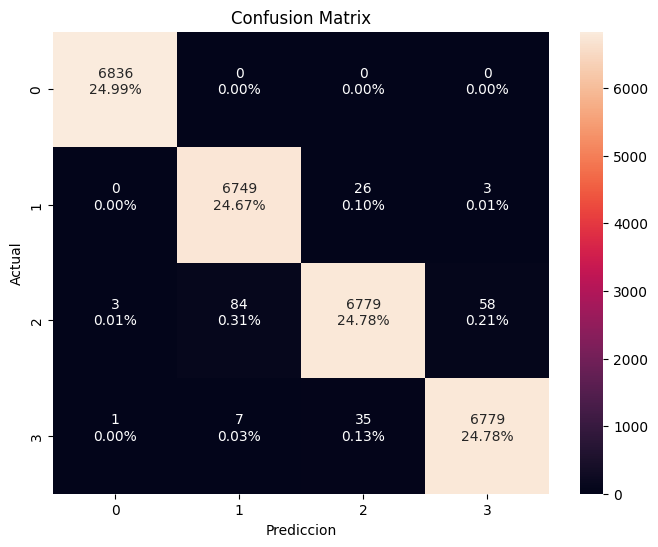

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6836
           1       0.99      1.00      0.99      6778
           2       0.99      0.98      0.99      6924
           3       0.99      0.99      0.99      6822

    accuracy                           0.99     27360
   macro avg       0.99      0.99      0.99     27360
weighted avg       0.99      0.99      0.99     27360

################## 6. Validar resultados de Modelo ####################
Accuracy:  99.21692251461988
Precision:  99.22037074910683
Recall:  99.21692251461988
F1-Score:  99.21777493017333


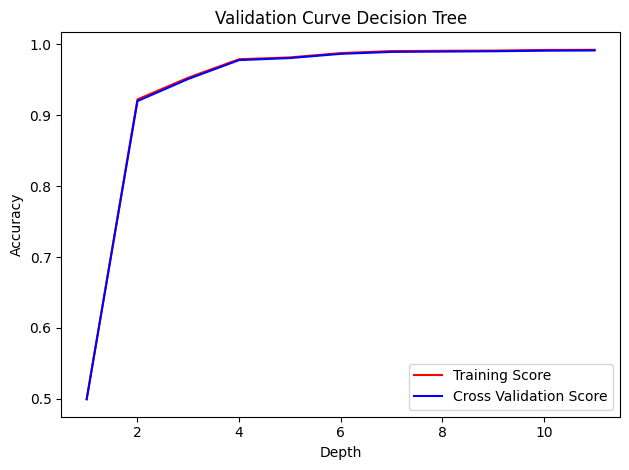

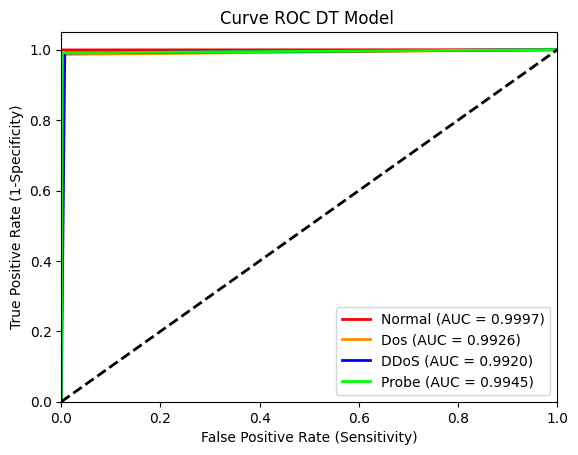

In [1]:
#----------------------------------------LIBRERIAS
import pandas as pd
import numpy as np
"""graficas"""
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
"""preprocesar"""
from sklearn.preprocessing import StandardScaler, label_binarize
"""dividir datos"""
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
"""validar modelo"""
from sklearn.model_selection import validation_curve, StratifiedKFold, GridSearchCV, cross_validate
"""metricas de evaluacion"""
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, make_scorer
"""modelos ML"""
from sklearn.tree import DecisionTreeClassifier


#----------------------------------------FUNCIONES
""" crear Funcion para matriz de confusion """
def crearMatriz_confusion(y_pred,y_test):
    cm= confusion_matrix(y_pred, y_test)
    plt.figure(figsize = (8,6))
    values = ["{0:0.0f}".format(x) for x in cm.flatten()]
    """ calcular y obtener valores"""
    percentages = ["{0:.2%}".format(x) for x in cm.flatten()/np.sum(cm)]
    combined = ["{}\n{}\n".format(j, k) for j, k in zip(values, percentages)]
    combined = np.asarray(combined).reshape(4,4)
    """crear matriz"""
    b = sns.heatmap(cm, annot=combined, fmt="")
    """etiquetas"""
    b.set(title='Confusion Matrix')
    b.set(xlabel='Prediccion', ylabel='Actual',)
    #plt.savefig('matrizconfusionDT_final.png')
    plt.show()

"""crear funcion para encontrar metricas del modelo """
def encontrar_metricas(y_test,y_pred):
    """ encontrar la precision del general del modelo"""
    accuracy = accuracy_score(y_test, y_pred)*100
    precision_ma = precision_score(y_test, y_pred, average='weighted')*100
    recall_ma = recall_score(y_test, y_pred, average='weighted')*100
    f1score_ma = f1_score(y_test, y_pred, average='weighted')*100
    return print('Accuracy: %s \nPrecision: %s \nRecall: %s \nF1-Score: %s' %(accuracy, precision_ma, recall_ma, f1score_ma))


#---------------------------------------- SELECCION DE DATOS
df_traffic = pd.read_csv('../../../araData/Z/balance_total4clases_34200.csv', low_memory=False)
"""matriz de caracteristicas"""
caracteristicas = ['Dur','protoTcp','protoUdp','portSystem','portUser','portDynamic','TotPkts', 'SrcPkts', 'DstPkts', 
                    'TotBytes', 'SrcBytes', 'DstBytes', 'Rate', 'SrcRate', 'DstRate']
print("############# 1. Caracteristicas: %s ###############" %len(caracteristicas) )

"""seleccion de variables"""
X= df_traffic[caracteristicas].values
y=df_traffic.iloc[:,-1].values

print("############# 2. Division de datos #############")
"""division de datos"""

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index,"\n")
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1 )
"""estandarizar datos"""
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


#----------------------------------------MODELO
print("############ 3. Seleccionando modelo #############")

"""validacion cruzada"""
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

"""Seleccion de modelo """
parametros_grid = [{'criterion':['gini','entropy','log_loss'],'max_depth':[5,6,7,8,9,10,11],
                    'ccp_alpha':[0.001, 0.01,0.5, 1, 5, 10],
                    'splitter': [ 'best', 'random' ]}]
dtree = DecisionTreeClassifier(class_weight = 'balanced', random_state=1)
grid_dt = GridSearchCV(estimator = dtree, param_grid = parametros_grid, cv = skf, n_jobs=-1)
grid_dt.fit(X_train, y_train)
print("Mejores hiperparametros: ", grid_dt.best_params_)
print("Mejor puntuacion: ", grid_dt.best_score_)
print("Modelo: ", grid_dt.best_estimator_)

print("############ 4. Entrenando modelo #############")
clf_dtree = DecisionTreeClassifier(criterion=grid_dt.best_params_['criterion'],
                                   max_depth = grid_dt.best_params_['max_depth'],
                                   splitter = grid_dt.best_params_['splitter'],
                                   ccp_alpha=grid_dt.best_params_['ccp_alpha'],
                                   random_state=1)
clf_dtree = clf_dtree.fit(X_train,y_train)
y_pred = clf_dtree.predict(X_test)
print("############ 4. Evaluando modelo #############")
y_pred = grid_dt.predict(X_test)
#----------------------------------------METRICAS Y EVALUACION
print("############ 5. Metricas del modelo #############")
""" metricas"""
encontrar_metricas(y_test,y_pred)
crearMatriz_confusion(y_pred,y_test)
print(classification_report(y_pred,y_test))#ver nro de instancias por clase

print('################## 6. Validar resultados de Modelo ####################')
score = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score, average='weighted'),
         'recall': make_scorer(recall_score, average='weighted'),'f1_score': make_scorer(f1_score, average= 'weighted')}

eval_resultado = cross_validate(estimator=clf_dtree, X=X_train, y=y_train, cv=skf, scoring=score)
print('Accuracy: ',  (np.mean(eval_resultado['test_accuracy'])*100))
print('Precision: ', (np.mean(eval_resultado['test_precision'])*100))
print('Recall: ', (np.mean(eval_resultado['test_recall'])*100))
print('F1-Score: ', (np.mean(eval_resultado['test_f1_score'])*100))


"""Grafica de entrenamiento del modelo"""
param_range = np.arange(1, (grid_dt.best_params_['max_depth']+1),1)
train_scores, test_scores = validation_curve(clf_dtree, X_train, y_train, 
                            param_name="max_depth", param_range=param_range,cv= skf,
                                             scoring="accuracy", n_jobs=-1)
"""calcular el promedio y desviacion standar del entrenamiento """
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
"""calcular el promedio y desviacion standar del conjunto de prueba """
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

"""mostrar valores obtenidos del conjunto de entrenamiento y prueba"""
plt.plot(param_range, train_scores_mean - train_scores_std,
     label = "Training Score", color = 'r')
plt.plot(param_range, test_scores_mean - test_scores_std,
   label = "Cross Validation Score", color = 'b')
 
"""crear grafica"""
plt.title("Validation Curve Decision Tree")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
#plt.savefig('DT_validationcurve.png')
plt.show()

"""CURVA ROC"""
y_lbtest = label_binarize(y_test,classes=[0, 1, 2, 3])
y_lbpred = label_binarize(y_pred,classes=[0, 1, 2, 3])
fpr = dict()
tpr = dict()
thresh=dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_lbtest[:,i], y_lbpred[:,i] )
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['red', 'darkorange', 'blue','lime'])
clases = ['Normal','Dos','DDoS', 'Probe']
for i, color, clase in zip(range(4), colors, clases):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.4f})'
             ''.format(clase, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate (1-Specificity)')
plt.title('Curve ROC DT Model ')
plt.legend(loc="lower right")
#plt.savefig('DT_curveroc.png')
plt.show()

In [2]:
import pickle 
pickle.dump(clf_dtree,open('dt_supermejorado.pkl','wb'))